In [1]:
import sys

sys.path.append('../../')

import numpy as np
import pylab as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import lightning as L

from sklearn import datasets

from dal_toolbox.models.utils.mcdropout import MCDropoutModule, ConsistentMCDropout
from dal_toolbox.models.mc_dropout import MCDropoutTrainer, MCDropoutModel
from dal_toolbox.models.utils.callbacks import MetricHistory

/home/denis/miniconda3/envs/dal-toolbox/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


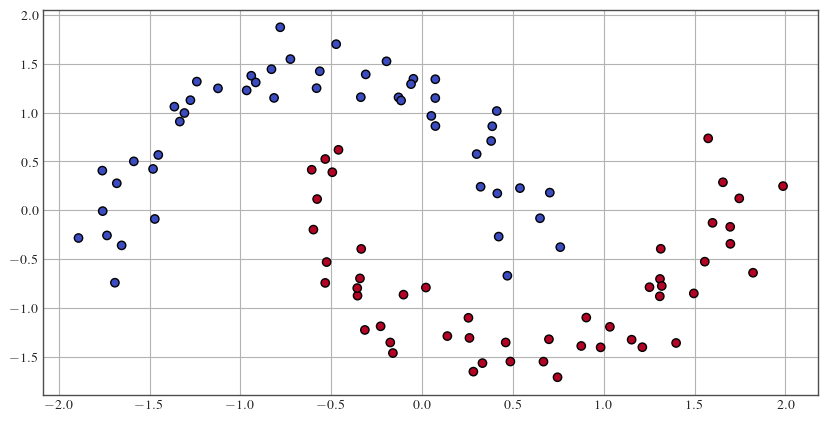

In [2]:
X, y = datasets.make_moons(100, noise=.1, random_state=42)
# X, y = datasets.make_circles(500, noise=.02)
X = (X - X.mean(0)) / X.std(0)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()

train_ds = torch.utils.data.TensorDataset(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [3]:
class Net(MCDropoutModule):
    def __init__(self,
                 num_classes: int,
                 dropout_rate: int = .2,
                 feature_dim: int = 128,
                 ):
        super().__init__(n_passes=50)

        self.first = nn.Linear(2, feature_dim)
        self.first_dropout = ConsistentMCDropout(dropout_rate)
        self.hidden = nn.Linear(feature_dim, feature_dim)
        self.hidden_dropout = ConsistentMCDropout(dropout_rate)
        self.last = nn.Linear(feature_dim, num_classes)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.first(x))
        x = self.first_dropout(x)
        x = self.act(self.hidden(x))
        x = self.hidden_dropout(x)
        out = self.last(x)
        return out

In [4]:
@torch.no_grad()
def plot_contour(model, X, y, ax=None):
    model.eval()
    model.cpu()
    if ax:
        plt.sca(ax)
    domain = 5
    xx, yy = torch.meshgrid(torch.linspace(-domain, domain, 51), torch.linspace(-domain, domain, 51))
    zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)

    logits = model.mc_forward(zz)
    probas = logits.softmax(-1)
    probas = probas.mean(1)
    zz = probas[:, 1].view(xx.shape)

    # plt.title(f"Ep {}")
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.contourf(xx, yy, zz, alpha=.8, zorder=-1, levels=np.linspace(0, 1, 6))
    plt.colorbar()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | model         | Net               | 17.2 K
1 | loss_fn       | CrossEntropyLoss  | 0     
2 | train_metrics | ModuleDict        | 0     
3 | val_metrics   | ModuleDict        | 0     
4 | val_loss_fn   | GibbsCrossEntropy | 0     
----------------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)


/home/denis/miniconda3/envs/dal-toolbox/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/home/denis/miniconda3/envs/dal-toolbox/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/denis/miniconda3/envs/dal-toolbox/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_wo

Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 61.89it/s, v_num=243, train_loss=0.0231, val_loss=0.0262] 

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 58.57it/s, v_num=243, train_loss=0.0231, val_loss=0.0262]


/home/denis/miniconda3/envs/dal-toolbox/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


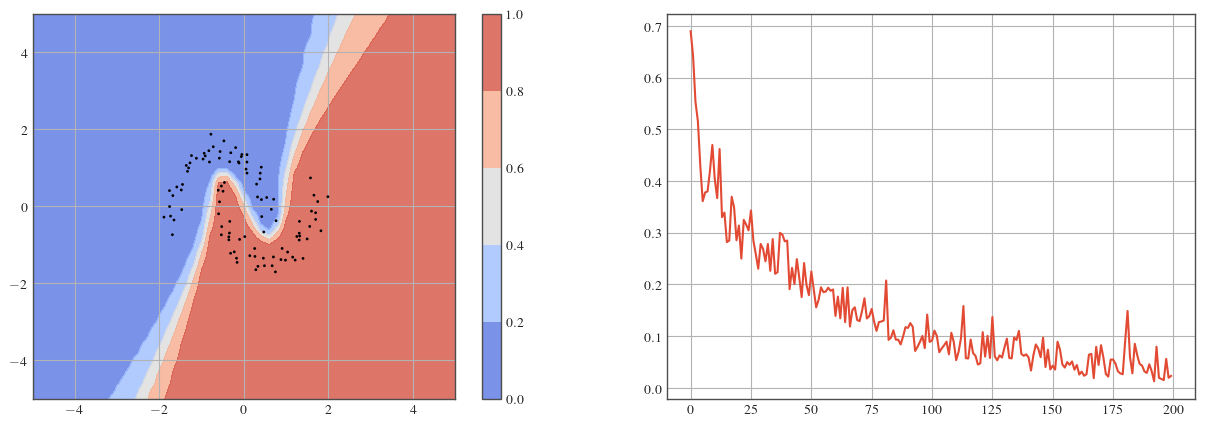

In [5]:
dropout_rate = 0.6
num_epochs = 200
torch.manual_seed(0)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True)

model = Net(dropout_rate=dropout_rate, num_classes=2)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, momentum=.9)
model = MCDropoutModel(model=model, optimizer=optimizer)

history = MetricHistory()
trainer = L.Trainer(max_epochs=num_epochs, callbacks=[history], enable_checkpointing=False)
trainer.fit(model, train_loader, val_dataloaders=train_loader)

model.eval()
plt.figure(figsize=(15, 5))
plt.subplot(122)
plt.plot([d['train_loss'] for d in history])
plot_contour(model, X, y, ax=plt.subplot(121))
plt.show()